# **SIFT (Scale-Invariant Feature Transform) Algorithm Overview**

SIFT is a robust computer vision technique for local feature detection and description.

## Steps:

1. **Scale Space:** Build Gaussian pyramids for different scales.
2. **DoG Pyramid:** Compute Difference of Gaussians for keypoint detection.
3. **Keypoint Detection:** Identify potential keypoints from DoG extrema.
4. **Keypoint Refinement:** Refine keypoints based on stability criteria.
5. **Orientation Assignment:** Assign dominant orientations to keypoints.
6. **Descriptor Generation:** Create local feature descriptors around keypoints.
7. **Matching and Recognition:** Match descriptors for object recognition, image stitching, etc.

SIFT's ability to detect and describe robust local features across scales makes it widely used in various computer vision applications.


### We first include necessary libraries and add a normalization function and a function for visualizing images

In [1]:
from matplotlib.patches import ConnectionPatch
from sklearn.neighbors import NearestNeighbors
from skimage.filters import sobel_h, sobel_v
from skimage.transform import rotate
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from matplotlib import gridspec
from skimage import transform
import skimage.io as io
import pandas as pd
import numpy as np
import time
import cv2
%matplotlib inline

In [2]:
def normalize_img(img):
    """
    Normalize pixel values of an image to the range [0, 1].

    Parameters:
    - img (numpy.ndarray): Input image as a NumPy array.

    Returns:
    - numpy.ndarray: Normalized image with pixel values in the range [0, 1].

    Example:
    >>> img = np.array([[10, 20, 30], [40, 50, 60]])
    >>> normalize_img(img)
    array([[0. , 0.2, 0.4],
           [0.6, 0.8, 1. ]])
    """
    img_min = np.min(img)
    img_max = np.max(img)
    normalized_img = (img - img_min) / (img_max - img_min)
    return normalized_img


In [3]:
def show_images(imgs, imgs_labels=None, figsize=(20, 10), show_axis=True):
    """
    Display images horizontally using Matplotlib subplots.

    Parameters:
    - imgs: List of images (NumPy arrays) to display.
    - imgs_labels: (Optional) List of labels corresponding to the images.

    Example Usage:
    show_images([image1, image2], ['Label 1', 'Label 2'])
    """
    # Create a figure with subplots based on the number of images
    fig, axes = plt.subplots(1, len(imgs), figsize=figsize)

    # Plot each image on its respective subplot
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], cmap="gray")  # Display image in grayscale
        if imgs_labels:
            axes[i].set_title(imgs_labels[i])  # Set title if labels provided
        
        if not show_axis:
            axes[i].set_axis_off()

    # Show the plot
    plt.tight_layout()
    plt.show()


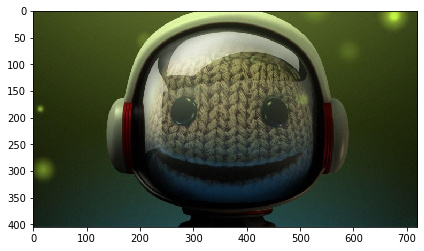

In [4]:
img_ = io.imread("images/img3.jpg")
io.imshow(img_)
plt.show()

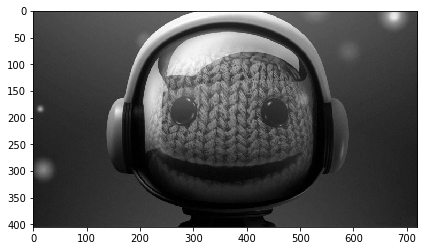

In [5]:
# convert to grayscale and normalize
img_ = normalize_img(rgb2gray(img_))
# img_ = transform.rotate(img_, 10)
io.imshow(img_, cmap='gray')
plt.show()

**Before starting, some terminologies must be clear**

Scale: Refers to the level or degree of Gaussian blurring applied to an image. It determines the amount of detail present in different versions of the same image.

Octave: A set of images having the same size, but with different scales (gaussian lvls)

Scale space: It encompasses the collection of octaves, each containing a series of images at varying scales (achieved by applying Gaussian blurring and downsampling). The scale space is essentially the entire set of images generated through different octaves and their respective scales.

## Step1: Construct Scale Space.


In [6]:
def downsample_img(img, lvls):
    """
    Generates a list of images by downsampling the input image at different levels.

    Parameters:
    - img: Input image (NumPy array).
    - lvls: List of downsampling levels.

    Returns:
    - generated_imgs: List of images downsampled at different levels.
    """
    generated_imgs = [cv2.resize(img, (0, 0), fx=1.0/lvl, fy=1.0/lvl) for lvl in lvls]
    return generated_imgs


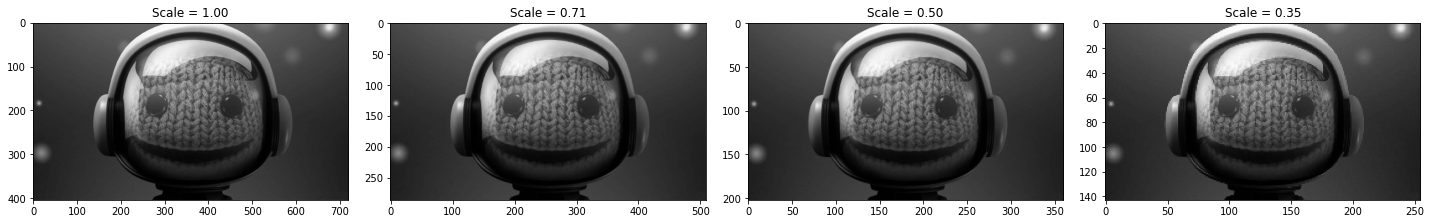

In [7]:
downsampling_lvls = [1.0]
num_downsamples = 4

for i in range(num_downsamples - 1):
    downsampling_lvls.append(np.sqrt(2) * downsampling_lvls[-1])

downsampled_imgs = downsample_img(img_, downsampling_lvls)
show_images(downsampled_imgs, [f"Scale = {1/i:.2f}" for i in downsampling_lvls])

In [8]:
def create_octave(img, sigmas):
    """
    Generates a list of images by applying Gaussian blur to the input image at different sigma values.

    Parameters:
    - img: Input image (NumPy array).
    - sigmas: List of sigma values for Gaussian blurring.

    Returns:
    - generated_imgs: List of images blurred at different sigma values.
    """
    blurred_images = [cv2.GaussianBlur(img, (0, 0), sigmaX=sigma, sigmaY=sigma) for sigma in sigmas]
    return blurred_images


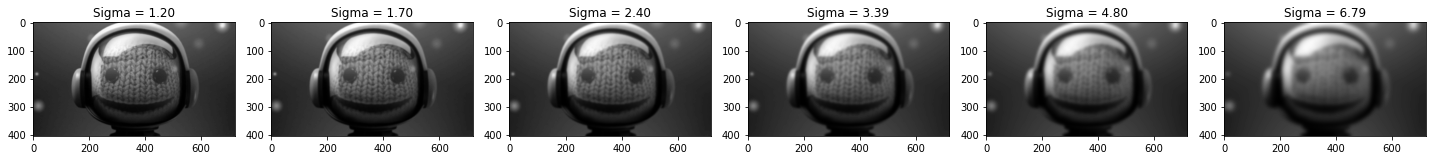

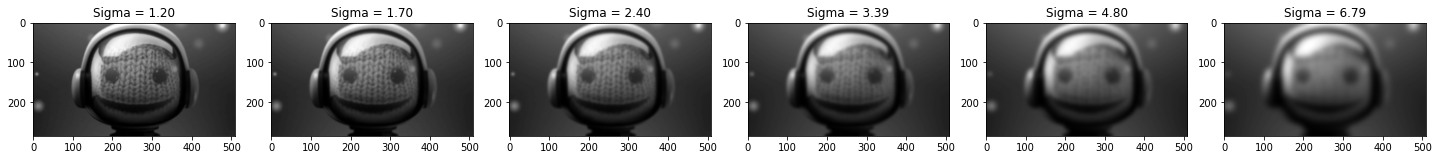

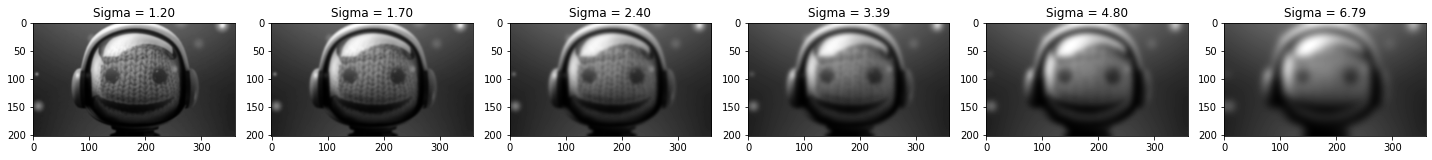

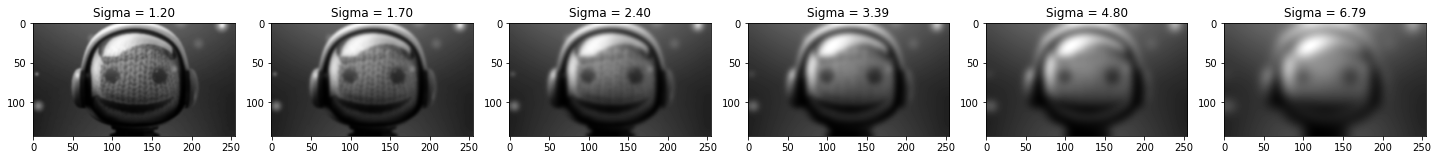

In [9]:
scale_space = []
sigma = 1.2
k = np.sqrt(2)

sigmas = [sigma, k * sigma, k**2 * sigma, k**3 * sigma, k**4 * sigma, k ** 5 * sigma]
for i in range(len(downsampled_imgs)):
    blurred_imgs = create_octave(downsampled_imgs[i], sigmas)
    show_images(blurred_imgs, [f"Sigma = {i:.2f}" for i in sigmas])
    scale_space.append(blurred_imgs)

## Step2: Compute Difference of Gaussians for keypoint detection.

In [10]:
def get_doG(imgs_list):
    """
    Computes the Difference of Gaussians (doG) for a list of images.

    Parameters:
    - imgs_list: List of images.

    Returns:
    - doG_list: List of images representing the differences between consecutive scales.
    """
    doG_list = [imgs_list[i] - imgs_list[i - 1] for i in range(1, len(imgs_list))]
    return doG_list

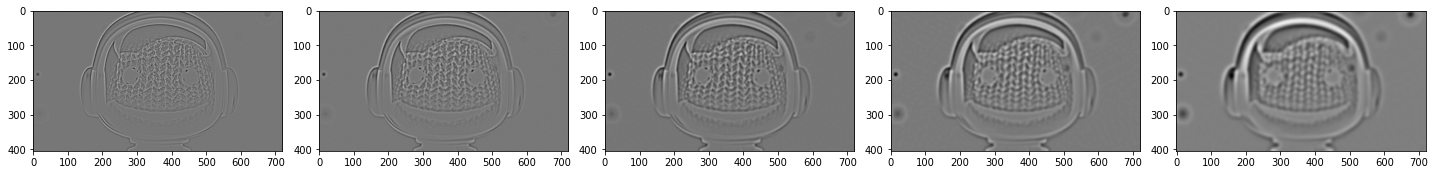

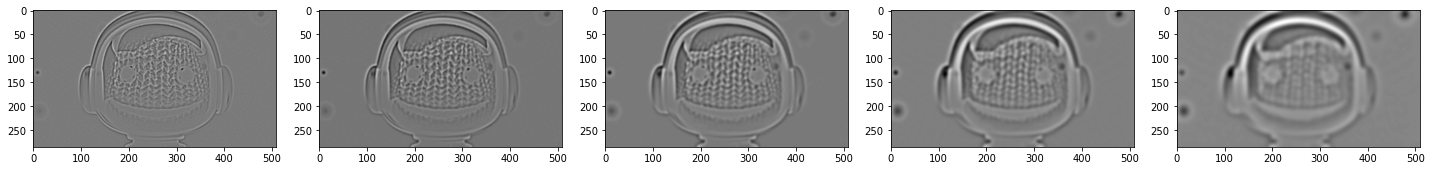

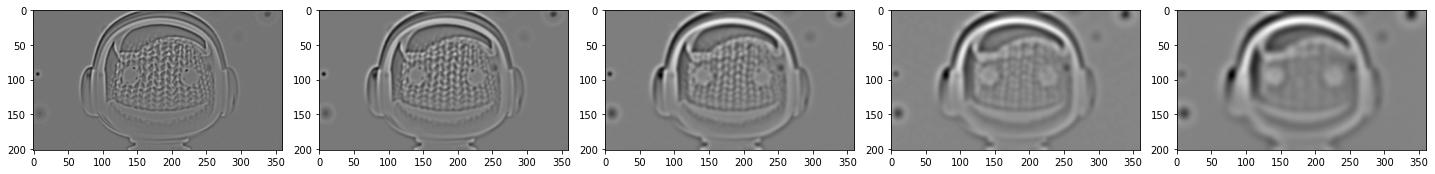

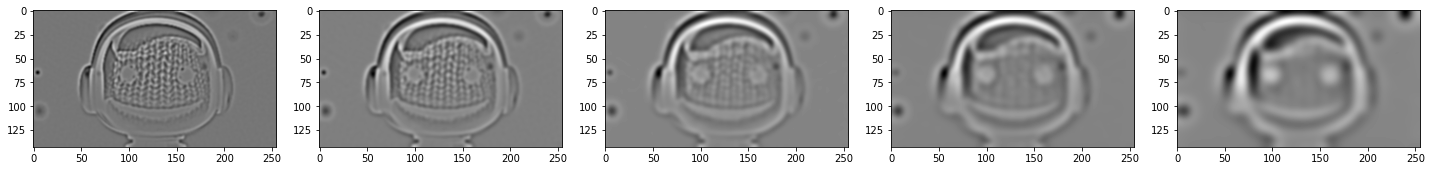

In [11]:
doG_space = []
for imgs_list in scale_space:
    doG_list = get_doG(imgs_list)
    doG_space.append(doG_list)
    show_images(doG_list)

## Step3: Keypoint Detection
Identify potential keypoints from doG extrema.

A keypoint in an image is a corner point, and in order to determine whether a point is a corner point or not, we use something called *Harris corner detector*

The Harris corner detector is an algorithm used in computer vision to identify corners or interest points in an image. It's not specifically an edge detector but is often used alongside edge detection methods for feature extraction.

#### Functionality

The Harris corner detection algorithm operates by:

1. **Image Gradients:**
   - Calculating gradients in the image to find changes in intensity in both x and y directions.

2. **Structure Tensor Calculation:**
   - Computing the structure tensor for each pixel, involving the products of gradients.

3. **Sum of Squares of Gradients:**
   - Calculating the sum of squares of gradients using the structure tensor elements.

4. **Corner Response Function:**
   - The cornerstone of the Harris corner detection algorithm is the corner response function.
   - It evaluates the local change in intensity for small displacements in different directions around a pixel.
   - The function assesses the significance of intensity changes when the image is shifted.
   - Mathematically, the corner response function is defined as:
     ```
     R = det(M) - k * trace(M)^2
     ```
     - Where:
       - `det(M)` is the determinant of the structure tensor `M`.
       - `trace(M)` is the trace of the structure tensor `M`.
       - `k` is an empirically determined constant (typically 0.04 to 0.06).
   - Higher values of `R` indicate a stronger response and a higher likelihood of the pixel being part of a corner or an interest point.

5. **Thresholding or Non-Maximum Suppression:**
   - Applying a threshold or non-maximum suppression to the computed corner response values to identify potential corners or interest points.


In [12]:
from numba import jit
@jit(nopython=True)
def get_keypoints(doG_list,  thresh=0.003):  # check that image values are between 0 and 1
    """
    Detects potential keypoints in Difference of Gaussian (doG) images.

    Args:
    - doG_list (list of arrays): A list containing Difference of Gaussian images.
    - thresh (float): Threshold value for identifying potential keypoints (default: 0.55).

    Returns:
    - total_keypoints (list of lists of tuples): A list containing coordinates of identified keypoints for each doG image.

    Notes:
    - The function iterates through the doG images in 'doG_list' and identifies potential keypoints.
    - 'thresh' determines the sensitivity of keypoint detection.
    - Output 'total_keypoints' contains lists of keypoints corresponding to each doG image.
    """
    candidate_keypoints = []
    H, W = doG_list[0].shape

    for y in range(1, H - 1):
        for x in range(1, W - 1):
            wind1 = doG_list[0][y - 1: y + 2, x - 1: x + 2]
            wind2 = doG_list[1][y - 1: y + 2, x - 1: x + 2]
            wind3 = doG_list[2][y - 1: y + 2, x - 1: x + 2]

            if np.abs(doG_list[1][y, x]) > thresh:
                if (doG_list[1][y, x] > max([np.max(wind1), np.max(wind3)]) or
                    doG_list[1][y, x] < min([np.min(wind1), np.min(wind3)])):

                    if (doG_list[1][y, x] == np.max(wind2) or doG_list[1][y, x] == np.min(wind2)):
                        candidate_keypoints.append((x, y))  # Swap x and y here
    
    return candidate_keypoints

## Step4: Keypoint Refinement
Refine keypoints based on stability criteria.

In [13]:
def filter_keypoints(img, keypoints, dxx, dyy, dxy, r=10, patch_size=5):
    """
    Filter keypoints based on the Hessian matrix determinant ratio.

    Parameters:
    - img: Input image.
    - keypoints: List of keypoints, where each keypoint is represented as a tuple (x, y).
    - dxx, dyy, dxy: Second derivatives of the image in x, y directions.
    - r: Parameter controlling the acceptance of keypoints based on Hessian determinant ratio.
        Keypoints with a ratio below ((r + 1)^2) / r are accepted.
    - patch_size: Size of the neighborhood patch for computing derivatives.

    Returns:
    List of filtered keypoints based on the Hessian determinant ratio.
    Each filtered keypoint is represented as a tuple (x, y).
    """
    filtered_keypoints = []

    for kp in keypoints:
        x, y = kp
        
        # Calculate the Hessian matrix at the keypoint location
        y_start, y_end = int(y - patch_size/2), int(y + patch_size/2)
        x_start, x_end = int(x - patch_size/2), int(x + patch_size/2)
        
        dxx_ = dxx[y_start:y_end, x_start:x_end]
        dyy_ = dyy[y_start:y_end, x_start:x_end]
        dxy_ = dxy[y_start:y_end, x_start:x_end]

        if dxx_.any():
            # Construct the Hessian matrix
            H = np.array([[np.sum(dxx_**2), np.sum(dxy_**2)],
                           [np.sum(dxy_**2), np.sum(dyy_**2)]])

            # Calculate the Hessian determinant ratio
            ratio = (H[0, 0] + H[1, 1])**2 / (np.linalg.det(H) + 1e-8)
            
            # Check if the keypoint satisfies the Hessian determinant ratio condition
            if(x < img.shape[1] - 1 and y < img.shape[0] - 1):
                if ratio < ((r + 1)**2) / r:
                    filtered_keypoints.append((x, y))
    return filtered_keypoints


In [14]:
# test keypoints filteration
keypoints = []
filtered_keypoints = []
for i in range(1, len(doG_list)-1):  # i is the scale (blur lvl)
    doG_i = doG_space[0][i]

    # get keypoints of this doG
    %time keypoints.extend(get_keypoints(np.array(doG_space[0])))  # numba is faster if the input is a np array

    # calculate first and second derivatives of the image in both x, y directions 
    dx = sobel_h(doG_i)
    dy = sobel_v(doG_i)
    dxx = sobel_h(dx)
    dyy = sobel_v(dy)
    dxy = sobel_h(dy)

    # calculate magnitude and direction for this doG img
    gradient_magnitude, gradient_orientation = cv2.cartToPolar(dx, dy, angleInDegrees=True)


    filtered_keypoints.extend(filter_keypoints(doG_i, keypoints, dxx, dyy, dxy))
        
    

Wall time: 2.53 s
Wall time: 68.8 ms
Wall time: 66.8 ms


In [15]:
doG_list = doG_space[0]
hh, ww = doG_list[0].shape
kps = []

for i in range(1, hh - 1):
    for j in range(1, ww - 1):
        wind1 = doG_list[0][i - 1: i + 2, j - 1: j + 2]
        wind2 = doG_list[1][i - 1: i + 2, j - 1: j + 2]
        wind3 = doG_list[2][i - 1: i + 2, j - 1: j + 2]
        
        if (doG_list[1][i, j] > np.max([np.max(wind1), np.max(wind3)]) or
            doG_list[1][i, j] < np.min([np.min(wind1), np.min(wind3)])):
            
            if (doG_list[1][i, j] == np.max(wind2) or doG_list[1][i, j] == np.min(wind2)):
                kps.append((i, j))


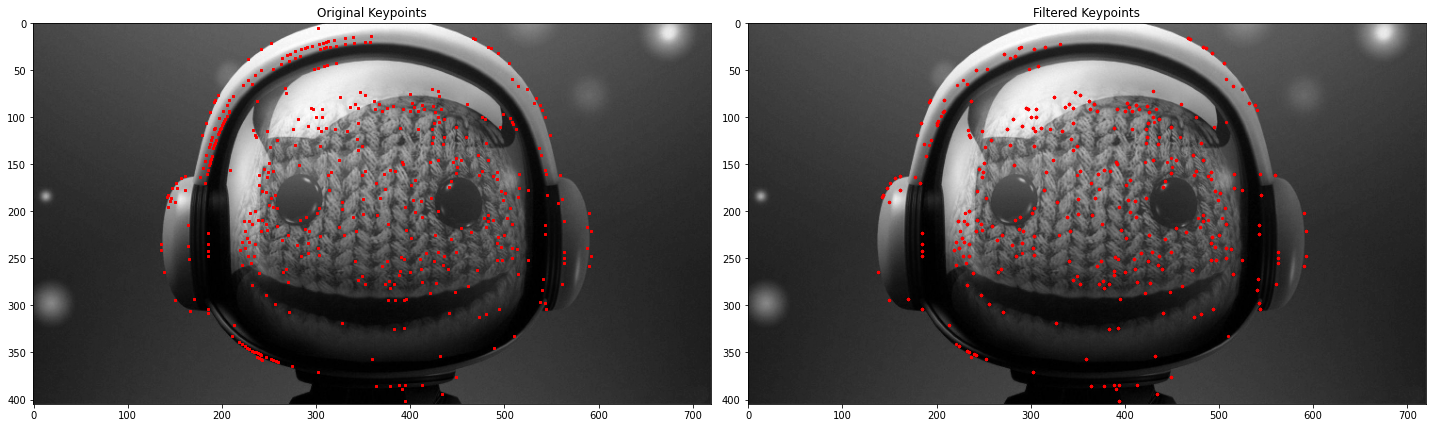

In [16]:
# plot keypoints before and after refinement
plt.figure(figsize=(20, 7))

x = [obj[0] for obj in keypoints]
y = [obj[1] for obj in keypoints]

plt.subplot(1, 2, 1)
plt.imshow(img_, cmap='gray')
plt.scatter(x, y, s=4, c="red")
plt.title('Original Keypoints')

# Filtered Keypoints plot
keypointsarr_filtered1 = np.array(filtered_keypoints)

plt.subplot(1, 2, 2)
plt.imshow(img_, cmap='gray')
plt.scatter(keypointsarr_filtered1[:, 0], keypointsarr_filtered1[:, 1], s=5, c="red")
plt.title('Filtered Keypoints')

plt.tight_layout()
plt.show()

## Step5: Orientation Assignment
Assign dominant orientations to keypoints.

In [17]:
def get_dominant_angles(filtered_keypoints, gradient_magnitude, gradient_orientation, patch_size=8):
    """
    Calculate dominant angles for filtered keypoints based on local gradient information.

    Parameters:
    - filtered_keypoints: List of filtered keypoints, where each keypoint is represented as a tuple (x, y).
    - gradient_magnitude: Gradient magnitude image.
    - gradient_orientation: Gradient orientation image.
    - patch_size: Size of the neighborhood patch for computing orientations.

    Returns:
    - orientation_data: Dictionary mapping each keypoint to a list of dominant angles.
    - new_filtered_keypoints: List of keypoints that passed the patch size check.
    """
    orientation_data = {}
    new_filtered_keypoints = []

    for kp in filtered_keypoints:
        x, y = kp
        y_start, y_end = int(y - patch_size / 2), int(y + patch_size / 2)
        x_start, x_end = int(x - patch_size / 2), int(x + patch_size / 2)
        patch_magnitude = gradient_magnitude[y_start:y_end, x_start:x_end]
        patch_orientation = gradient_orientation[y_start:y_end, x_start:x_end]

        if patch_magnitude.shape == (patch_size, patch_size):
            # Flatten the orientation and magnitude arrays
            flat_magnitude = patch_magnitude.flatten()
            flat_orientation = patch_orientation.flatten()

            # Calculate the weighted histogram of orientations
            hist, bins = np.histogram(flat_orientation, bins=36, range=(0, 360), weights=flat_magnitude)

            # Find the bin index with the maximum value
            max_bin_index = np.argmax(hist)

            # Convert the bin index to the corresponding orientation value
            max_orientation = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2

            orientation_data[kp[:2]] = [max_orientation]
            new_filtered_keypoints.append(kp)

            # Check for additional prominent angles (>0.8 times the peak value)
            hist = np.delete(hist, max_bin_index)
            other_bins = np.where(hist > 0.8 * max_orientation)[0]

            if len(other_bins) > 0:
                orientation_data[kp[:2]].extend([(bins[bin] + bins[bin + 1]) / 2 for bin in other_bins])

    return orientation_data, new_filtered_keypoints


## Step 6: Descriptor Generation
Create local feature descriptors around keypoints.

In [18]:
@jit(nopython=True)
def sobel_numba(img):
    """
    Apply the Sobel operator to compute the gradient magnitude and orientation of an image.

    Parameters:
    - img (numpy.ndarray): Input grayscale image.

    Returns:
    - tuple: A tuple containing two arrays - the gradient magnitude and orientation in degrees.
      The gradient magnitude represents the strength of edges, and the orientation provides
      the direction of the edges.

    Example:
    ```python
    import numpy as np
    magnitude, orientation = sobel_numba(image)
    ```
    """
    rows, cols = img.shape
    grad_x = np.zeros_like(img)
    grad_y = np.zeros_like(img)

    # Sobel kernels
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # Compute gradient in x-direction
            gx = np.sum(img[i-1:i+2, j-1:j+2] * kernel_x)
            # Compute gradient in y-direction
            gy = np.sum(img[i-1:i+2, j-1:j+2] * kernel_y)

            grad_x[i, j] = gx
            grad_y[i, j] = gy

    # Compute magnitude and orientation
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    orientation = np.arctan2(grad_y, grad_x)
    orientation_deg = np.degrees(orientation)
    
    return magnitude, orientation_deg


In [19]:
@jit(nopython=True)
def compute_weighted_histogram(window, weights, num_bins):
    """
    Compute a weighted histogram from a window of values.

    Parameters:
    - window (numpy.ndarray): 2D array representing the window of values.
    - weights (numpy.ndarray): 2D array of the same shape as the window, representing weights
      associated with each value in the window.
    - num_bins (int): Number of bins for the histogram.

    Returns:
    - numpy.ndarray: 1D array representing the weighted histogram.

    """
    hist = np.array([0 for i in range(num_bins)])
    min_val = -180
    max_val = 180

    bin_edges = np.linspace(min_val, max_val, num_bins + 1)

    for i in range(window.shape[0]):
        for j in range(window.shape[1]):
            value = window[i, j]
            weight = weights[i, j]

            bin_index = np.searchsorted(bin_edges, value, side='right') - 1
            if 0 <= bin_index < num_bins:
                hist[bin_index] += weight

    return hist


In [20]:
@jit(nopython=True)
def get_hist(array, nbins=8):
    """
    Compute weighted histogram of gradient orientations from an input array.

    Parameters:
    - array (numpy.ndarray): Input array for gradient orientation computation.
    - nbins (int): Number of bins for the histogram (default: 8).

    Returns:
    - numpy.ndarray: Weighted histogram of gradient orientations.
    """
    gradient_magnitude, gradient_orientation = sobel_numba(array * 256)
    return compute_weighted_histogram(gradient_orientation, gradient_magnitude, nbins)


In [21]:
def get_descriptor(doG_i, kp, rot_angle, patch_size=16, subarray_size=4, func=get_hist):
    """
    Generates a sift descriptor for a keypoint in an image.

    Parameters:
    - doG_i (numpy.ndarray): The Difference of Gaussians (DoG) image from which the descriptor is computed.
    - kp (tuple): Keypoint coordinates (x, y) for which the descriptor is generated.
    - rot_angle (float): Rotation angle in degrees representing the dominant orientation of the keypoint.
    - patch_size (int, optional): Size of the square patch around the keypoint. Default is 16.
    - subarray_size (int, optional): Size of the subarrays within the patch. Default is 4.
    - func (function, optional): Function used to compute the feature vector for each subarray. Default is get_hist.

    Returns:
    - normalized_feature_vector (numpy.ndarray): Normalized feature vector representing the sift descriptor.

    Note:
    - The function checks boundaries to ensure that the generated patch around the keypoint is within the image limits.
    - The patch is rotated using the specified dominant angle before computing the feature vector.
    - The feature vector is obtained by applying the specified function to subarrays within the rotated patch.
    - The resulting feature vector is normalized to ensure invariance to scale and illumination changes.

    Example usage:
    descriptor = get_descriptor(doG_image, (x, y), rotation_angle)
    """

    half_patch = patch_size // 2
    x, y = kp

    # Check boundaries
    x_start = max(x - half_patch, 0)
    y_start = max(y - half_patch, 0)
    x_end = min(x + half_patch, doG_i.shape[1] - 1)
    y_end = min(y + half_patch, doG_i.shape[0] - 1)
    
    patch = doG_i[y_start:y_end, x_start:x_end]
    if patch.shape != (16, 16):
        return []

    # Rotate patch with the dominant angle
    patch = rotate(patch, angle=rot_angle, resize=False, preserve_range=True)

    feature_vector = []
    for row in range(0, patch_size, subarray_size):
        for col in range(0, patch_size, subarray_size):
            subarray = patch[row:min(row + subarray_size, patch_size), col:min(col + subarray_size, patch_size)]
            result = func(subarray)
            feature_vector.extend(result)

    norm = np.linalg.norm(feature_vector)
    if norm:
        normalized_feature_vector = feature_vector / norm
    else:
        normalized_feature_vector = feature_vector

    return normalized_feature_vector


In [22]:
def extract_sift_data(img, sigmas, downsampling_lvls=[1], doG_thresh=0.003, r=10, return_descriptor_only=False):
    """
    Extracts sift keypoints and descriptors from an input image using the Scale-Invariant Feature Transform (sift) algorithm.

    Parameters:
    - img (numpy.ndarray): Input image in the form of a NumPy array.
    - sigmas (list): List of standard deviations for the Gaussian kernels used in creating the scale space.
    - downsampling_lvls (list, optional): List of downsampling levels for creating different sizes of the image. Default is [1].
    - doG_thresh (float, optional): Threshold for the Difference of Gaussians (DoG) values to identify keypoints. Default is 0.003.
    - r (int, optional): Radius for filtering keypoints based on the Hessian matrix. Default is 10.

    Returns:
    - sift_summary (pandas.DataFrame): DataFrame containing sift keypoints and descriptors with columns:
        - "Position": Keypoint position (x, y).
        - "Size": Keypoint size.
        - "Orientation": Dominant orientation of the keypoint.
        - "Descriptor": sift descriptor for the keypoint.
    """

    sift_summary = pd.DataFrame(columns=["Position", "Size", "Orientation", "Descriptor"])

    # Generate different sizes of the image
    downsampled_imgs = downsample_img(img, downsampling_lvls)

    # Create scale space
    scale_space = []
    for i in range(len(downsampled_imgs)):
        octave = create_octave(downsampled_imgs[i], sigmas)
        scale_space.append(octave)

    for s, imgs_list in enumerate(scale_space):
        doG_list = np.array(get_doG(imgs_list))

        for i in range(1, len(doG_list)-1):  # i is the scale (blur lvl)
            doG_i = doG_list[i].astype(np.float32)

            # Get keypoints of this doG
            keypoints = get_keypoints(np.array(doG_list), doG_thresh)

            # Calculate first and second derivatives of the image in both x, y directions
            dx = cv2.Sobel(doG_i, cv2.CV_64F, 1, 0, ksize=3)
            dy = cv2.Sobel(doG_i, cv2.CV_64F, 0, 1, ksize=3)
            dxx = cv2.Sobel(dx, cv2.CV_64F, 1, 0, ksize=3)
            dyy = cv2.Sobel(dy, cv2.CV_64F, 0, 1, ksize=3)
            dxy = cv2.Sobel(dy, cv2.CV_64F, 1, 0, ksize=3)

            # Calculate magnitude and direction for this doG img
            gradient_magnitude, gradient_orientation = cv2.cartToPolar(dx, dy, angleInDegrees=True)

            # Filter keypoints to include only corner points
            filtered_keypoints = filter_keypoints(doG_i, keypoints, dxx, dyy, dxy, r=r)

            orientation_data, filtered_keypoints = get_dominant_angles(filtered_keypoints, gradient_magnitude, gradient_orientation)

            start = time.time()

            for kp in filtered_keypoints:
                for angle in orientation_data[kp[:2]]:
                    descriptor = get_descriptor(doG_i, kp, angle)
                    if len(descriptor):
                        data = [kp, 1/downsampling_lvls[s], angle, descriptor]
                        sift_summary.loc[len(sift_summary)] = data
            # print(f"Time: {time.time() - start}")
    
    if(return_descriptor_only):
        return sift_summary["Descriptor"].to_list()
    return sift_summary


In [23]:
# get descriptors of the current image
sigma = 1.2
k = np.sqrt(1.8)

downsampling_lvls = [1.0]  # Starting scale factor, e.g., 1.0
num_downsamples = 4

for i in range(num_downsamples - 1):
    downsampling_lvls.append(np.sqrt(2) * downsampling_lvls[-1])

sigmas = [sigma, k * sigma, k**2 * sigma, k**3 * sigma, k**4 * sigma, k**5 * sigma]
%time sift_summary = extract_sift_data(img_, sigmas, downsampling_lvls)

Wall time: 8.4 s


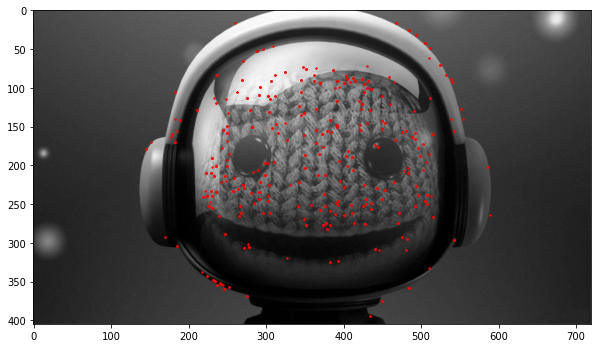

In [24]:
x, y= zip(*sift_summary[sift_summary["Size"] == 1]["Position"].to_list())
fig = plt.figure(figsize=(10, 8))
plt.imshow(img_, cmap='gray')  # Display the image
plt.scatter(list(x), list(y), color='red', s=2)  # Scatter plot the point (x, y) in red color
plt.show()

## Testing Scale invariance

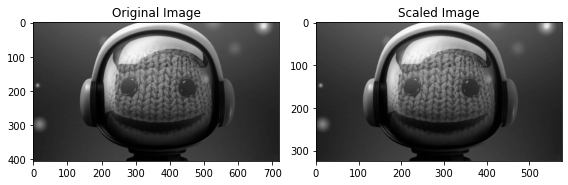

In [25]:
# Create two images with different scales
img_1 = img_
img_2 = transform.rescale(img_1, 0.8)
show_images([img_1, img_2], ["Original Image", "Scaled Image"], figsize=(8, 5))

In [26]:
def find_closest_neighbors(img1, img2):
    """
    Finds the nearest neighbors for sift feature points between two images.

    Parameters:
    - img1: The first input image.
    - img2: The second input image.
    - descriptor_threshold: The threshold for sift feature point extraction.

    Returns:
    - distances: Array of distances to the nearest neighbors for each feature point in image 2.
    - indices: Array of indices of the nearest neighbors for each feature point in image 2.
    - sift_summary1: Summary of sift feature points and descriptors for image 1.
    - sift_summary2: Summary of sift feature points and descriptors for image 2.
    """

    # Get sift feature points and descriptors for each image
    sift_summary1 = extract_sift_data(img1, sigmas, downsampling_lvls)
    sift_summary2 = extract_sift_data(img2, sigmas)

    # Get the number of neighbors to find (in this case, the nearest neighbor)
    num_neighbors = 1

    # Initialize and fit the nearest neighbors model on data from image 1
    nn_model = NearestNeighbors(n_neighbors=num_neighbors, algorithm='kd_tree')
    nn_model.fit(sift_summary1["Descriptor"].to_list())

    # Find nearest neighbors for each feature point in image 2
    distances, indices = nn_model.kneighbors(sift_summary2["Descriptor"].to_list())

    return distances, indices, sift_summary1, sift_summary2


In [27]:
def extract_common_features(sift_summary1, sift_summary2, distances, indices, distance_threshold):
    """
    Extracts common features between two sets of sift feature summaries.

    Parameters:
    - sift_summary1: sift feature summary for the first set of images.
    - sift_summary2: sift feature summary for the second set of images.
    - distances: Array of distances to the nearest neighbors for each feature point in sift_summary2.
    - indices: Array of indices of the nearest neighbors for each feature point in sift_summary2.
    - distance_threshold: Threshold distance for selecting common features.

    Returns:
    - x1, y1, x2, y2: Coordinates of common features in both sets.
    - scale_factor: Most common scale (Size) in the sift features.
    """

    # Choose feature points based on the distance threshold
    filtered_indices = indices[distances < distance_threshold]
    corresponding_rows_sift_summary1 = sift_summary1.iloc[filtered_indices].reset_index()

    # Get corresponding rows from sift_summary2 using filtered indices
    corresponding_rows_sift_summary2 = sift_summary2.iloc[distances < distance_threshold].reset_index()

    # Determine the most common scale (Size) in the sift features
    scale_factor = corresponding_rows_sift_summary1["Size"].value_counts().idxmax()

    # Get indices of rows with the specified scale_factor
    indices_filtered_rows1 = corresponding_rows_sift_summary1[corresponding_rows_sift_summary1["Size"] == scale_factor].index

    # Extract corresponding rows from both sift summary DataFrames
    filtered_rows_sift_summary1 = corresponding_rows_sift_summary1.loc[indices_filtered_rows1]
    filtered_rows_sift_summary2 = corresponding_rows_sift_summary2.loc[indices_filtered_rows1]

    # Get x, y points from both sift summary DataFrames to plot
    xy1 = np.array(filtered_rows_sift_summary1["Position"].to_list())[:, :2]
    x1, y1 = xy1[:, 0], xy1[:, 1]

    xy2 = np.array(filtered_rows_sift_summary2["Position"].to_list())[:, :2]
    x2, y2 = xy2[:, 0], xy2[:, 1]

    return x1, y1, x2, y2, scale_factor

In [28]:
def plot_sift_images(img1, img2, x1, x2, y1, y2, scale_factor):
    """
    Plot sift keypoints on two images and connect corresponding points.

    Parameters:
    - img1: First image (numpy array).
    - img2: Second image (numpy array).
    - x1: x-coordinates of keypoints in image 1.
    - x2: x-coordinates of keypoints in image 2.
    - y1: y-coordinates of keypoints in image 1.
    - y2: y-coordinates of keypoints in image 2.
    - scale_factor: Scale factor used for resizing image 1.

    Returns:
    None (displays the plot).
    """
    # Creating subplots with width ratios
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Plotting scatter points on image 1
    ax1 = plt.subplot(gs[0])
    ax1.imshow(transform.rescale(img1, scale_factor), cmap='gray')
    ax1.scatter(x1, y1, color='red', s=5)

    # Plotting scatter points on image 2
    ax2 = plt.subplot(gs[1])
    ax2.imshow(img2, cmap='gray')
    ax2.scatter(x2, y2, color='blue', s=5)

    # Connecting points with ConnectionPatch
    for i in range(len(x1)):
        xyA = (x1[i], y1[i])
        xyB = (x2[i], y2[i])
        con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                              axesA=ax1, axesB=ax2, color="darkgreen", linewidth=0.5)
        ax2.add_artist(con)
    plt.show()


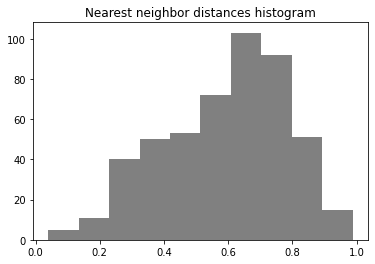

In [29]:
distances, indices, sift_summary1, sift_summary2 = find_closest_neighbors(img_1, img_2)
plt.hist(distances, color='gray')
plt.title("Nearest neighbor distances histogram")
plt.show()

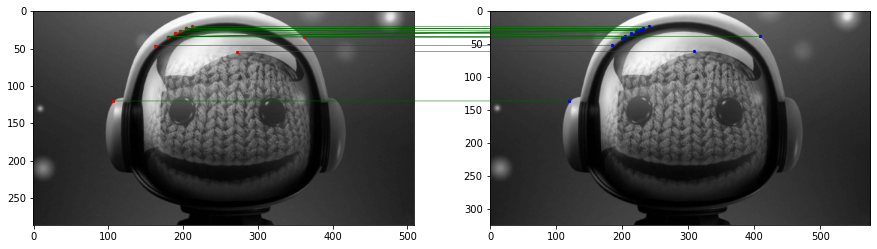

In [30]:
# Matching SIFT Keypoints in Image A and Image B
x1, y1, x2, y2, scale_factor = extract_common_features(sift_summary1, sift_summary2, distances, indices, 0.25)
plot_sift_images(img_1, img_2, x1, x2, y1, y2, scale_factor)

## Testing Rotation Invariance

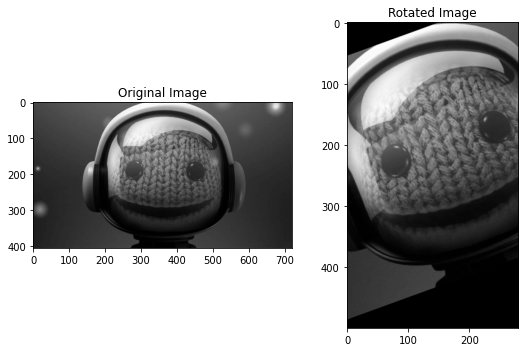

In [31]:
# rotate image with 90 degree
img_3 = transform.rotate(img_1, 20, resize=True, preserve_range=False)[100: 600, 250 : 530]
show_images([img_1, img_3], ["Original Image", "Rotated Image"], figsize=(8, 5))

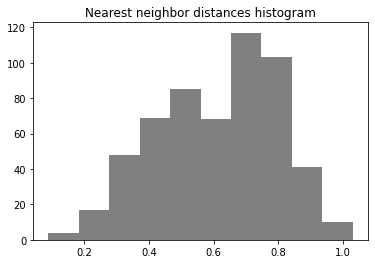

In [32]:
distances, indices, sift_summary1, sift_summary3 = find_closest_neighbors(img_1, img_3)
plt.hist(distances, color='gray')
plt.title("Nearest neighbor distances histogram")
plt.show()

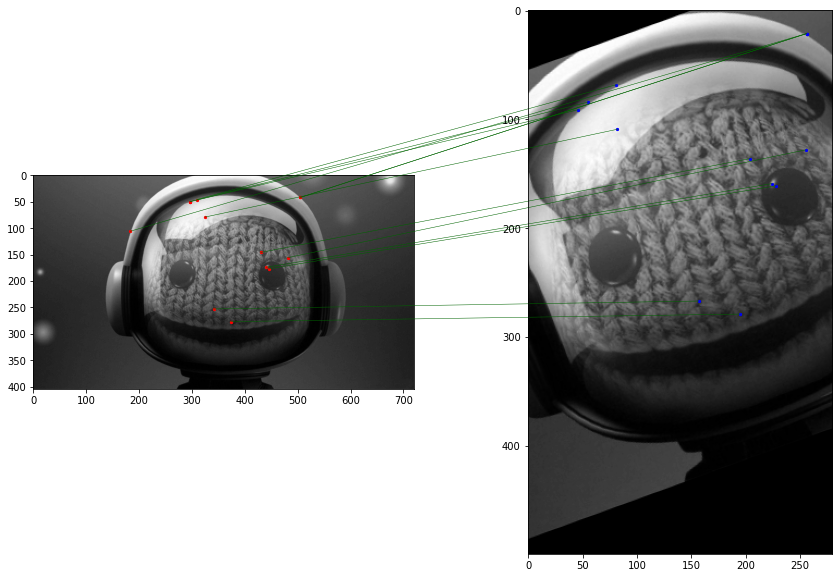

In [33]:
# Matching SIFT Keypoints in Image A and Image B
x1, y1, x2, y2, scale_factor = extract_common_features(sift_summary1, sift_summary3, distances, indices, 0.25)
plot_sift_images(img_1, img_3, x1, x2, y1, y2, scale_factor)

In [34]:
def display_windows_around_points(image1, image2, x_coordinates1, y_coordinates1,
                                  x_coordinates2, y_coordinates2, window_size=40, num_displayed_points=4):
    """
    Display windows around randomly selected points in two images.

    Parameters:
    - image1: The first input image.
    - image2: The second input image.
    - x_coordinates1, y_coordinates1: Coordinates of points in image1.
    - x_coordinates2, y_coordinates2: Corresponding coordinates of points in image2.
    - window_size: Size of the displayed windows.
    - num_displayed_points: Number of points to display.

    Returns:
    None
    """
    # Create a figure with two rows and specified number of columns
    fig, axs = plt.subplots(2, num_displayed_points, figsize=(16, 6))

    for i in range(num_displayed_points):
        index = np.random.randint(0, high=len(x_coordinates1) - 1)

        # Extract the window around the point in image1
        window_image1 = image1[y_coordinates1[index] - window_size//2:y_coordinates1[index] + window_size//2,
                               x_coordinates1[index] - window_size//2:x_coordinates1[index] + window_size//2]

        # Extract the window around the corresponding point in image2
        window_image2 = image2[y_coordinates2[index] - window_size//2:y_coordinates2[index] + window_size//2,
                               x_coordinates2[index] - window_size//2:x_coordinates2[index] + window_size//2]

        # Display the window in image1
        axs[0, i].imshow(window_image1, cmap='gray', aspect='auto')
        axs[0, i].set_title(f'Point {index + 1} in Image 1')

        # Display the window in image2
        axs[1, i].imshow(window_image2, cmap='gray', aspect='auto')
        axs[1, i].set_title(f'Point {index + 1} in Image 2')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

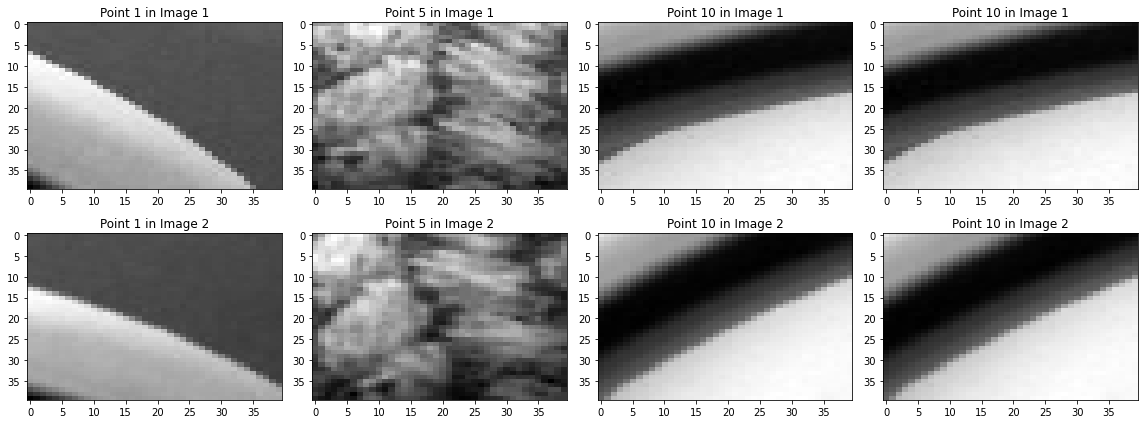

In [35]:
display_windows_around_points(img_1, img_3, x1, y1, x2, y2)

---
## End of Notebook
This notebook covers how to implement SIFT algorithm from scratch in python. Feel free to explore further or adapt the code for your projects.